# 注意力汇聚：Nadaraya-Watson 核回归
:label:`sec_nadaraya-watson`

上节介绍了框架下的注意力机制的主要成分 :numref:`fig_qkv`：
查询（自主提示）和键（非自主提示）之间的交互形成了注意力汇聚；
注意力汇聚有选择地聚合了值（感官输入）以生成最终的输出。
本节将介绍注意力汇聚的更多细节，
以便从宏观上了解注意力机制在实践中的运作方式。
具体来说，1964年提出的Nadaraya-Watson核回归模型
是一个简单但完整的例子，可以用于演示具有注意力机制的机器学习。


In [6]:
import torch
from torch import nn
from d2l import torch as d2l

## [**生成数据集**]

简单起见，考虑下面这个回归问题：
给定的成对的“输入－输出”数据集
$\{(x_1, y_1), \ldots, (x_n, y_n)\}$，
如何学习$f$来预测任意新输入$x$的输出$\hat{y} = f(x)$？

根据下面的非线性函数生成一个人工数据集，
其中加入的噪声项为$\epsilon$：

$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$$

其中$\epsilon$服从均值为$0$和标准差为$0.5$的正态分布。
在这里生成了$50$个训练样本和$50$个测试样本。
为了更好地可视化之后的注意力模式，需要将训练样本进行排序。


In [7]:
n_train = 50  # 训练样本数
x_train, sorted_indices = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本
print("x_train.shape", x_train.shape)
print("x_train", x_train)
print("sorted_indices", sorted_indices)

x_train.shape torch.Size([50])
x_train tensor([0.1153, 0.2747, 0.3125, 0.4233, 0.5627, 0.6849, 0.7425, 0.8280, 0.9134,
        1.0666, 1.2414, 1.2885, 1.3068, 1.3241, 1.5586, 1.5644, 1.6337, 1.6882,
        1.8751, 1.9123, 1.9435, 1.9710, 2.0002, 2.0671, 2.6170, 2.6173, 2.6666,
        2.7885, 2.9607, 3.1657, 3.1853, 3.2805, 3.3574, 3.5776, 3.6955, 3.7028,
        3.7424, 3.8575, 3.9391, 3.9647, 4.0088, 4.0495, 4.1890, 4.3348, 4.3404,
        4.5798, 4.5810, 4.6457, 4.6625, 4.6732])
sorted_indices tensor([21,  8,  5, 32, 41, 36, 39, 37, 34, 18, 48, 17,  4, 42, 24, 29, 20, 14,
        43, 19,  7, 27, 28, 31, 46, 23, 22, 15,  6,  3, 47, 30, 44, 45, 49, 16,
        35, 10, 26,  1, 40,  0,  9, 11, 13,  2, 12, 25, 33, 38])


In [8]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
print("y_train", y_train)
x_test = torch.arange(0, 5, 0.1)  # 测试样本
print("x_test", x_test)
y_truth = f(x_test)  # 测试样本的真实输出
print("y_truth", y_truth)
n_test = len(x_test)  # 测试样本数
print("n_test", n_test)

y_train tensor([0.5117, 1.2428, 0.9391, 1.7541, 1.6662, 1.7012, 0.8054, 1.5769, 2.3864,
        3.1229, 2.8981, 3.6287, 4.3734, 3.4268, 3.4738, 4.4576, 2.7725, 2.2941,
        3.8043, 4.0246, 3.6518, 4.1378, 3.3652, 3.8826, 3.5077, 3.4205, 1.6832,
        3.2492, 1.5733, 2.3212, 2.8544, 2.9566, 1.8410, 1.3632, 1.3979, 2.1330,
        1.2072, 2.2797, 1.8416, 1.6225, 2.4103, 2.0286, 0.8386, 1.9037, 2.1434,
        0.5814, 1.0968, 1.7151, 1.2216, 1.7373])
x_test tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
        4.5000, 4.6000, 4.7000, 4.8000, 4.9000])
y_truth tensor([0.0000, 0.3582, 0.6733, 0.9727, 1.2593, 1.5332, 1.7938, 2.0402, 2.2712,

下面的函数将绘制所有的训练样本（样本由圆圈表示），
不带噪声项的真实数据生成函数$f$（标记为“Truth”），
以及学习得到的预测函数（标记为“Pred”）。


In [9]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)
    # d2l.plt.show() # 如果是.py文件，就需要加上这一行

## 平均汇聚

先使用最简单的估计器来解决回归问题。
基于平均汇聚来计算所有训练样本输出值的平均值：

$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$
:eqlabel:`eq_avg-pooling`

如下图所示，这个估计器确实不够聪明。
真实函数$f$（“Truth”）和预测函数（“Pred”）相差很大。


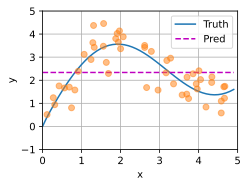

In [10]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## [**非参数注意力汇聚**]

显然，平均汇聚忽略了输入$x_i$。
于是Nadaraya :cite:`Nadaraya.1964`和
Watson :cite:`Watson.1964`提出了一个更好的想法，
根据输入的位置对输出$y_i$进行加权：

$$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$$
:eqlabel:`eq_nadaraya-watson`

其中$K$是*核*（kernel）。
公式 :eqref:`eq_nadaraya-watson`所描述的估计器被称为
*Nadaraya-Watson核回归*（Nadaraya-Watson kernel regression）。
这里不会深入讨论核函数的细节，
但受此启发，
我们可以从 :numref:`fig_qkv`中的注意力机制框架的角度
重写 :eqref:`eq_nadaraya-watson`，
成为一个更加通用的*注意力汇聚*（attention pooling）公式：

$$f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i,$$
:eqlabel:`eq_attn-pooling`

其中$x$是查询，$(x_i, y_i)$是键值对。
比较 :eqref:`eq_attn-pooling`和 :eqref:`eq_avg-pooling`，
注意力汇聚是$y_i$的加权平均。
将查询$x$和键$x_i$之间的关系建模为
*注意力权重*（attention weight）$\alpha(x, x_i)$，
如 :eqref:`eq_attn-pooling`所示，
这个权重将被分配给每一个对应值$y_i$。
对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布：
它们是非负的，并且总和为1。

为了更好地理解注意力汇聚，
下面考虑一个*高斯核*（Gaussian kernel），其定义为：

$$K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).$$

将高斯核代入 :eqref:`eq_attn-pooling`和
 :eqref:`eq_nadaraya-watson`可以得到：

$$\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}$$
:eqlabel:`eq_nadaraya-watson-gaussian`

**<font color = red>在 :eqref:`eq_nadaraya-watson-gaussian`中，
如果一个键$x_i$越是接近给定的查询$x$，
那么分配给这个键对应值$y_i$的注意力权重就会越大，
也就“获得了更多的注意力”。</font>**

值得注意的是，Nadaraya-Watson核回归是一个非参数模型。
因此， :eqref:`eq_nadaraya-watson-gaussian`是
*非参数的注意力汇聚*（nonparametric attention pooling）模型。
接下来，我们将基于这个非参数的注意力汇聚模型来绘制预测结果。
从绘制的结果会发现新的模型预测线是平滑的，并且比平均汇聚的预测更接近真实。


X_repeat.shape torch.Size([50, 50])
X_repeat tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        ...,
        [4.7000, 4.7000, 4.7000,  ..., 4.7000, 4.7000, 4.7000],
        [4.8000, 4.8000, 4.8000,  ..., 4.8000, 4.8000, 4.8000],
        [4.9000, 4.9000, 4.9000,  ..., 4.9000, 4.9000, 4.9000]])
x_train.shape torch.Size([50])
x_train tensor([0.1153, 0.2747, 0.3125, 0.4233, 0.5627, 0.6849, 0.7425, 0.8280, 0.9134,
        1.0666, 1.2414, 1.2885, 1.3068, 1.3241, 1.5586, 1.5644, 1.6337, 1.6882,
        1.8751, 1.9123, 1.9435, 1.9710, 2.0002, 2.0671, 2.6170, 2.6173, 2.6666,
        2.7885, 2.9607, 3.1657, 3.1853, 3.2805, 3.3574, 3.5776, 3.6955, 3.7028,
        3.7424, 3.8575, 3.9391, 3.9647, 4.0088, 4.0495, 4.1890, 4.3348, 4.3404,
        4.5798, 4.5810, 4.6457, 4.6625, 4.6732])
attention_weights.shape torch.Size([50, 50])
attention_weights tensor

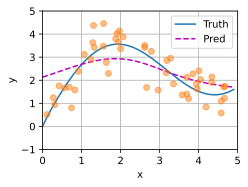

In [17]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
print("X_repeat.shape", X_repeat.shape)
print("X_repeat", X_repeat)
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
print("x_train.shape", x_train.shape)
print("x_train", x_train)
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
print("attention_weights.shape", attention_weights.shape)
print("attention_weights", attention_weights)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
print("y_train.shape", y_train.shape)
print("y_hat.shape", y_hat.shape)
print("y_hat", y_hat)
plot_kernel_reg(y_hat)

现在来观察注意力的权重。
这里测试数据的输入相当于查询，而训练数据的输入相当于键。
因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近，
注意力汇聚的[**注意力权重**]就越高。


tmp.shape torch.Size([1, 1, 50, 50])


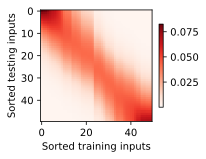

In [18]:
tmp = attention_weights.unsqueeze(0).unsqueeze(0)
print("tmp.shape", tmp.shape)

d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## [**带参数注意力汇聚**]

非参数的Nadaraya-Watson核回归具有*一致性*（consistency）的优点：
如果有足够的数据，此模型会收敛到最优结果。
尽管如此，我们还是可以轻松地将可学习的参数集成到注意力汇聚中。

例如，与 :eqref:`eq_nadaraya-watson-gaussian`略有不同，
在下面的查询$x$和键$x_i$之间的距离乘以可学习参数$w$：

$$\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}$$
:eqlabel:`eq_nadaraya-watson-gaussian-para`

本节的余下部分将通过训练这个模型
 :eqref:`eq_nadaraya-watson-gaussian-para`来学习注意力汇聚的参数。

### 批量矩阵乘法

:label:`subsec_batch_dot`

为了更有效地计算小批量数据的注意力，
我们可以利用深度学习开发框架中提供的批量矩阵乘法。

假设第一个小批量数据包含$n$个矩阵$\mathbf{X}_1,\ldots, \mathbf{X}_n$，
形状为$a\times b$，
第二个小批量包含$n$个矩阵$\mathbf{Y}_1, \ldots, \mathbf{Y}_n$，
形状为$b\times c$。
它们的批量矩阵乘法得到$n$个矩阵
$\mathbf{X}_1\mathbf{Y}_1, \ldots, \mathbf{X}_n\mathbf{Y}_n$，
形状为$a\times c$。
因此，[**假定两个张量的形状分别是$(n,a,b)$和$(n,b,c)$，
它们的批量矩阵乘法输出的形状为$(n,a,c)$**]。


In [22]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
tmp = torch.bmm(X, Y)
print("tmp.shape", tmp.shape)
print("tmp", tmp)

tmp.shape torch.Size([2, 1, 6])
tmp tensor([[[4., 4., 4., 4., 4., 4.]],

        [[4., 4., 4., 4., 4., 4.]]])


在注意力机制的背景中，我们可以[**使用小批量矩阵乘法来计算小批量数据中的加权平均值**]。


In [23]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
result = torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))
print("weights", weights.unsqueeze(1).shape, weights.unsqueeze(1))
print("values", values.unsqueeze(-1).shape, values.unsqueeze(-1))
print("result", result.shape, result)

weights torch.Size([2, 1, 10]) tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]],

        [[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]]])
values torch.Size([2, 10, 1]) tensor([[[ 0.],
         [ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 7.],
         [ 8.],
         [ 9.]],

        [[10.],
         [11.],
         [12.],
         [13.],
         [14.],
         [15.],
         [16.],
         [17.],
         [18.],
         [19.]]])
result torch.Size([2, 1, 1]) tensor([[[ 4.5000]],

        [[14.5000]]])


### 定义模型

基于 :eqref:`eq_nadaraya-watson-gaussian-para`中的
[**带参数的注意力汇聚**]，使用小批量矩阵乘法，
定义Nadaraya-Watson核回归的带参数版本为：


In [27]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

### 训练

接下来，[**将训练数据集变换为键和值**]用于训练注意力模型。
在带参数的注意力汇聚模型中，
*任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算，
从而得到其对应的预测输出。*


In [28]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# keys实际上是将原来X_tile每行去掉一个元素，每行去掉的元素是原来X_tile对角线上的那个元素
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

print("X_tile.shape", X_tile.shape)
print("X_tile", X_tile)
print("Y_tile.shape", Y_tile.shape)
print("Y_tile", Y_tile)
print("keys.shape", keys.shape)
print("keys", keys)
print("values.shape", values.shape)
print("values", values)

X_tile.shape torch.Size([50, 50])
X_tile tensor([[0.1153, 0.2747, 0.3125,  ..., 4.6457, 4.6625, 4.6732],
        [0.1153, 0.2747, 0.3125,  ..., 4.6457, 4.6625, 4.6732],
        [0.1153, 0.2747, 0.3125,  ..., 4.6457, 4.6625, 4.6732],
        ...,
        [0.1153, 0.2747, 0.3125,  ..., 4.6457, 4.6625, 4.6732],
        [0.1153, 0.2747, 0.3125,  ..., 4.6457, 4.6625, 4.6732],
        [0.1153, 0.2747, 0.3125,  ..., 4.6457, 4.6625, 4.6732]])
Y_tile.shape torch.Size([50, 50])
Y_tile tensor([[0.5117, 1.2428, 0.9391,  ..., 1.7151, 1.2216, 1.7373],
        [0.5117, 1.2428, 0.9391,  ..., 1.7151, 1.2216, 1.7373],
        [0.5117, 1.2428, 0.9391,  ..., 1.7151, 1.2216, 1.7373],
        ...,
        [0.5117, 1.2428, 0.9391,  ..., 1.7151, 1.2216, 1.7373],
        [0.5117, 1.2428, 0.9391,  ..., 1.7151, 1.2216, 1.7373],
        [0.5117, 1.2428, 0.9391,  ..., 1.7151, 1.2216, 1.7373]])
keys.shape torch.Size([50, 49])
keys tensor([[0.2747, 0.3125, 0.4233,  ..., 4.6457, 4.6625, 4.6732],
        [0.1153, 0.31

[**训练带参数的注意力汇聚模型**]时，使用平方损失函数和随机梯度下降。


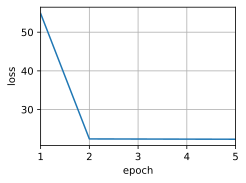

In [29]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

epoch_list = []
l_sum_list = []

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    epoch_list.append(epoch+1)
    l_sum_list.append(l.sum())
    animator.add(epoch + 1, float(l.sum()))


# NOTE: 这里不知道为什么按照原来的写法没法print都是一闪而过的，所以用list收集了下数据，然后最后再print出来
# for epoch, l_sum in zip(epoch_list, l_sum_list):
#     print("epoch", epoch, "l_sum", float(l_sum))

如下所示，训练完带参数的注意力汇聚模型后可以发现：
在尝试拟合带噪声的训练数据时，
[**预测结果绘制**]的线不如之前非参数模型的平滑。


keys.shape torch.Size([50, 50])
keys tensor([[0.1153, 0.2747, 0.3125,  ..., 4.6457, 4.6625, 4.6732],
        [0.1153, 0.2747, 0.3125,  ..., 4.6457, 4.6625, 4.6732],
        [0.1153, 0.2747, 0.3125,  ..., 4.6457, 4.6625, 4.6732],
        ...,
        [0.1153, 0.2747, 0.3125,  ..., 4.6457, 4.6625, 4.6732],
        [0.1153, 0.2747, 0.3125,  ..., 4.6457, 4.6625, 4.6732],
        [0.1153, 0.2747, 0.3125,  ..., 4.6457, 4.6625, 4.6732]])
values.shape torch.Size([50, 50])
values tensor([[0.5117, 1.2428, 0.9391,  ..., 1.7151, 1.2216, 1.7373],
        [0.5117, 1.2428, 0.9391,  ..., 1.7151, 1.2216, 1.7373],
        [0.5117, 1.2428, 0.9391,  ..., 1.7151, 1.2216, 1.7373],
        ...,
        [0.5117, 1.2428, 0.9391,  ..., 1.7151, 1.2216, 1.7373],
        [0.5117, 1.2428, 0.9391,  ..., 1.7151, 1.2216, 1.7373],
        [0.5117, 1.2428, 0.9391,  ..., 1.7151, 1.2216, 1.7373]])
y_hat.shape torch.Size([50, 1])
y_hat tensor([[0.5239],
        [0.6104],
        [0.9239],
        [1.1657],
        [1.4258]

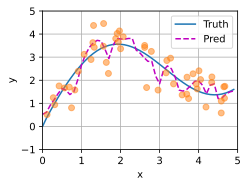

In [31]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
print("keys.shape", keys.shape)
print("keys", keys)
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
print("values.shape", values.shape)
print("values", values)
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
print("y_hat.shape", y_hat.shape)
print("y_hat", y_hat)
plot_kernel_reg(y_hat)

为什么新的模型更不平滑了呢？
下面看一下输出结果的绘制图：
与非参数的注意力汇聚模型相比，
带参数的模型加入可学习的参数后，
[**曲线在注意力权重较大的区域变得更不平滑**]。


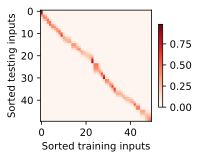

In [32]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## 小结

* Nadaraya-Watson核回归是具有注意力机制的机器学习范例。
* Nadaraya-Watson核回归的注意力汇聚是对训练数据中输出的加权平均。从注意力的角度来看，分配给每个值的注意力权重取决于将值所对应的键和查询作为输入的函数。
* 注意力汇聚可以分为非参数型和带参数型。

## 练习

1. 增加训练数据的样本数量，能否得到更好的非参数的Nadaraya-Watson核回归模型？
1. 在带参数的注意力汇聚的实验中学习得到的参数$w$的价值是什么？为什么在可视化注意力权重时，它会使加权区域更加尖锐？
1. 如何将超参数添加到非参数的Nadaraya-Watson核回归中以实现更好地预测结果？
1. 为本节的核回归设计一个新的带参数的注意力汇聚模型。训练这个新模型并可视化其注意力权重。


[Discussions](https://discuss.d2l.ai/t/5760)
